In [48]:
import os
import cv2
import numpy as np
import matplotlib.cm as cm
import tensorflow as tf
import random
import PIL
from PIL import Image, ImageOps
import scipy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import Input

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import splitfolders
%matplotlib inline

In [49]:
os.listdir(f'rooms_dataset/train')  # Directory where training data folders are

['baño', 'exterior', 'zonas_comunes', 'zona_comercial', 'cocina', 'habitación']

In [51]:
num_classes = len(os.listdir(f'rooms_dataset/train'))
dataset_dir ="rooms_dataset"
target_size = (224, 224) #vgg16, resnet152, mobilenet
#target_size = (299, 299) #inceptionv3
batch_size = 32  # Training batch size
print(num_classes)

6


In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# preprocessing image and divide validaiton set
train_datagen = ImageDataGenerator(horizontal_flip=True, 
                                   brightness_range=[0.5,1.5], 
                                   zoom_range=[0.3,1], 
                                   rotation_range=5)

train_generator = train_datagen.flow_from_directory(dataset_dir+'/train',
                                                 target_size=target_size,
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='training')

validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_directory(dataset_dir+'/val',
                                                            target_size=target_size,
                                                            batch_size=batch_size,
                                                            class_mode='categorical')


Found 815 images belonging to 6 classes.
Found 206 images belonging to 6 classes.


In [6]:
classes = train_generator.class_indices
print(classes)

{'baño': 0, 'cocina': 1, 'exterior': 2, 'habitación': 3, 'zona_comercial': 4, 'zonas_comunes': 5}


In [7]:
class_names = list(classes.keys())

In [8]:
import math
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K

early_stop = EarlyStopping(monitor='val_loss',
                           patience=30,
                           restore_best_weights=True,
                           mode='min')

checkpoint = ModelCheckpoint('logs/ep{epoch:03}-val_loss{val_loss:.3f}.h5', monitor='val_loss',save_best_only=True, verbose=1)

### VGG16

In [48]:
vgg16_model = vgg16.VGG16(weights = 'imagenet' , include_top=False, input_shape = (224, 224, 3))
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [49]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in vgg16_model.layers:
    layer.trainable = False

#if fine_tune es decir cuantas capas quieres reentrenar
# for layer in base_model.layers[:-fine_tune]:
# layer.traineble = False

vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [50]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# save the output of the last layer to be the input of the next layer
last_layer = vgg16_model.output

# flatten the classifier input which is output of the last layer of VGG16 model
x = Flatten(name="flatten")(last_layer)
#x = Dense(50, activation='relu')(x)
#x = Dense(30, activation='relu')(x)
x = Dense(num_classes, activation='softmax', name='softmax')(x)

# instantiate a new_model using keras’s Model class
new_vgg16_model = Model(inputs=vgg16_model.input, outputs=x)

# print the new_model summary
new_vgg16_model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [51]:
new_vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
history_vgg16 = new_vgg16_model.fit(train_generator, batch_size=batch_size, validation_data=validation_generator, epochs=100, verbose=2, callbacks=[checkpoint, early_stop])

Epoch 1/100

Epoch 1: val_loss improved from inf to 5.71866, saving model to logs/ep001-val_loss5.719.h5
26/26 - 200s - loss: 7.0722 - accuracy: 0.6160 - val_loss: 5.7187 - val_accuracy: 0.7718 - 200s/epoch - 8s/step
Epoch 2/100

Epoch 2: val_loss improved from 5.71866 to 3.92393, saving model to logs/ep002-val_loss3.924.h5
26/26 - 184s - loss: 4.0609 - accuracy: 0.7939 - val_loss: 3.9239 - val_accuracy: 0.8155 - 184s/epoch - 7s/step
Epoch 3/100

Epoch 3: val_loss did not improve from 3.92393
26/26 - 177s - loss: 2.6715 - accuracy: 0.8429 - val_loss: 4.0404 - val_accuracy: 0.8350 - 177s/epoch - 7s/step
Epoch 4/100

Epoch 4: val_loss did not improve from 3.92393
26/26 - 199s - loss: 2.1347 - accuracy: 0.8675 - val_loss: 6.9158 - val_accuracy: 0.7961 - 199s/epoch - 8s/step
Epoch 5/100

Epoch 5: val_loss did not improve from 3.92393
26/26 - 190s - loss: 2.5164 - accuracy: 0.8724 - val_loss: 4.3144 - val_accuracy: 0.8447 - 190s/epoch - 7s/step
Epoch 6/100

Epoch 6: val_loss did not improve

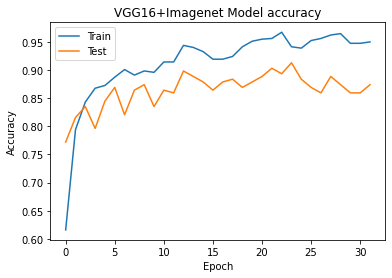

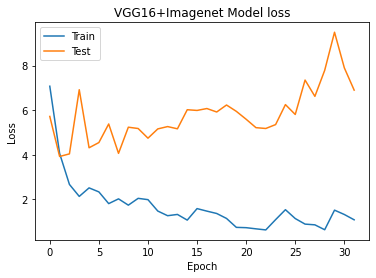

In [54]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('VGG16+Imagenet Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title('VGG16+Imagenet Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [55]:
x, y = zip(*(validation_generator[i] for i in range(len(validation_generator))))
x_test, y_test = np.vstack(x), np.vstack(y)
loss, acc = new_vgg16_model.evaluate(x_test, y_test, batch_size=32)

print("Accuracy: " ,acc)
print("Loss: ", loss)

7/7 [==============================] - 36s 5s/step - loss: 3.9239 - accuracy: 0.8155
Accuracy:  0.8155339956283569
Loss:  3.923933506011963


### VGG16 + Places365

In [9]:
#Get the places356 weights
weights_file = 'vgg16-places365_weights_tf_dim_ordering_tf_kernels_notop.h5'
weights_path = tf.keras.utils.get_file(weights_file, 'https://github.com/GKalliatakis/Keras-VGG16-places365/releases/download/v1.0/vgg16-places365_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [10]:
vgg16_places_model = vgg16.VGG16(weights = weights_path , include_top=False, input_shape = (224, 224, 3))
vgg16_places_model.summary()

2022-08-08 11:34:46.936595: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/irene/tfm_env/tfm_env/lib/python3.8/site-packages/cv2/../../lib64:/home/irene/tfm_ros_ws/devel/lib:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu
2022-08-08 11:34:46.936712: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-08 11:34:46.936789: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (irene-HP-Laptop-15-bs1xx): /proc/driver/nvidia/version does not exist
2022-08-08 11:34:46.954277: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable 

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in vgg16_places_model.layers:
    layer.trainable = False

#if fine_tune es decir cuantas capas quieres reentrenar
# for layer in base_model.layers[:-fine_tune]:
# layer.traineble = False

vgg16_places_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# save the output of the last layer to be the input of the next layer
last_layer = vgg16_places_model.output

# flatten the classifier input which is output of the last layer of VGG16 model
x = Flatten(name="flatten")(last_layer)
#x = Dense(50, activation='relu')(x)
#x = Dense(30, activation='relu')(x)
x = Dense(num_classes, activation='softmax', name='softmax')(x)

# instantiate a new_model using keras’s Model class
new_vgg16_places_model = Model(inputs=vgg16_places_model.input, outputs=x)

# print the new_model summary
new_vgg16_places_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
new_vgg16_places_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_vgg16_places = new_vgg16_places_model.fit(train_generator, batch_size=batch_size, validation_data=validation_generator, epochs=100, verbose=2, callbacks=[checkpoint, early_stop])

Epoch 1/100


2022-08-08 11:35:17.341460: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 447741952 exceeds 10% of free system memory.
2022-08-08 11:35:18.348078: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 447741952 exceeds 10% of free system memory.
2022-08-08 11:35:19.009573: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 111935488 exceeds 10% of free system memory.
2022-08-08 11:35:19.079094: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 223870976 exceeds 10% of free system memory.
2022-08-08 11:35:19.353612: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 223870976 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 3.72587, saving model to logs/ep001-val_loss3.726.h5
26/26 - 218s - loss: 7.1223 - accuracy: 0.6209 - val_loss: 3.7259 - val_accuracy: 0.8107 - 218s/epoch - 8s/step
Epoch 2/100

Epoch 2: val_loss did not improve from 3.72587
26/26 - 184s - loss: 2.6425 - accuracy: 0.8196 - val_loss: 4.2015 - val_accuracy: 0.8204 - 184s/epoch - 7s/step
Epoch 3/100

Epoch 3: val_loss improved from 3.72587 to 3.40707, saving model to logs/ep003-val_loss3.407.h5
26/26 - 178s - loss: 2.5602 - accuracy: 0.8577 - val_loss: 3.4071 - val_accuracy: 0.8447 - 178s/epoch - 7s/step
Epoch 4/100

Epoch 4: val_loss improved from 3.40707 to 3.04110, saving model to logs/ep004-val_loss3.041.h5
26/26 - 181s - loss: 1.8715 - accuracy: 0.8724 - val_loss: 3.0411 - val_accuracy: 0.8592 - 181s/epoch - 7s/step
Epoch 5/100

Epoch 5: val_loss did not improve from 3.04110
26/26 - 178s - loss: 1.7112 - accuracy: 0.8957 - val_loss: 3.6705 - val_accuracy: 0.8641 - 178s/epoch - 7s/step
Epoch 6/1

Epoch 47/100

Epoch 47: val_loss did not improve from 2.91193
26/26 - 183s - loss: 0.5083 - accuracy: 0.9742 - val_loss: 6.9703 - val_accuracy: 0.8689 - 183s/epoch - 7s/step
Epoch 48/100

Epoch 48: val_loss did not improve from 2.91193
26/26 - 180s - loss: 0.7592 - accuracy: 0.9546 - val_loss: 6.5527 - val_accuracy: 0.8786 - 180s/epoch - 7s/step
Epoch 49/100

Epoch 49: val_loss did not improve from 2.91193
26/26 - 181s - loss: 0.4845 - accuracy: 0.9718 - val_loss: 5.5268 - val_accuracy: 0.9126 - 181s/epoch - 7s/step
Epoch 50/100

Epoch 50: val_loss did not improve from 2.91193
26/26 - 185s - loss: 0.5556 - accuracy: 0.9742 - val_loss: 5.7927 - val_accuracy: 0.9126 - 185s/epoch - 7s/step
Epoch 51/100

Epoch 51: val_loss did not improve from 2.91193
26/26 - 180s - loss: 0.5110 - accuracy: 0.9767 - val_loss: 7.4545 - val_accuracy: 0.8689 - 180s/epoch - 7s/step
Epoch 52/100

Epoch 52: val_loss did not improve from 2.91193
26/26 - 180s - loss: 0.4192 - accuracy: 0.9828 - val_loss: 6.3978 - 

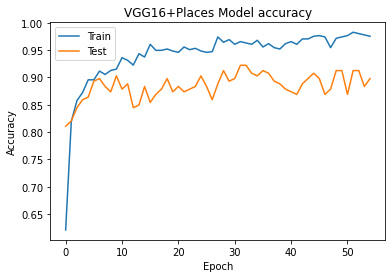

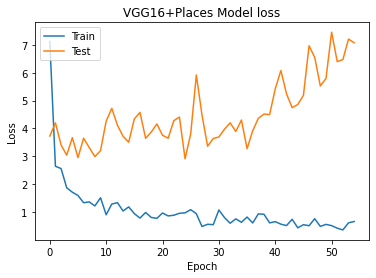

In [14]:
plt.plot(history_vgg16_places.history['accuracy'])
plt.plot(history_vgg16_places.history['val_accuracy'])
plt.title('VGG16+Places Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_vgg16_places.history['loss'])
plt.plot(history_vgg16_places.history['val_loss'])
plt.title('VGG16+Places Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
x, y = zip(*(validation_generator[i] for i in range(len(validation_generator))))
x_test, y_test = np.vstack(x), np.vstack(y)
loss, acc = new_vgg16_places_model.evaluate(x_test, y_test, batch_size=32)

print("Accuracy: " ,acc)
print("Loss: ", loss)

7/7 [==============================] - 36s 5s/step - loss: 2.9119 - accuracy: 0.9029
Accuracy:  0.9029126167297363
Loss:  2.911929130554199


### ResNet50

In [54]:
resnet50_model = resnet50.ResNet50(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))
resnet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_9[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [55]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in resnet50_model.layers:
    layer.trainable = False

#if fine_tune es decir cuantas capas quieres reentrenar
# for layer in base_model.layers[:-fine_tune]:
# layer.traineble = False

resnet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_9[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [56]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# save the output of the last layer to be the input of the next layer
last_layer = resnet50_model.output

# flatten the classifier input which is output of the last layer of ResNet152 model
x = Flatten(name="flatten")(last_layer)
#x = Dense(1000, activation='relu')(x)
#x = Dense(50, activation='relu')(x)
#x = Dense(30, activation='relu')(x)
x = Dense(num_classes, activation='softmax', name='softmax')(x)

# instantiate a new_model using keras’s Model class
new_resnet50_model = Model(inputs=resnet50_model.input, outputs=x)

# print the new_model summary
new_resnet50_model.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_9[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [57]:
new_resnet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_resnet50_model = new_resnet50_model.fit(train_generator, batch_size=batch_size, validation_data=validation_generator, epochs=100, verbose=2, callbacks=[checkpoint, early_stop])

Epoch 1/100

Epoch 1: val_loss did not improve from 1.40615
26/26 - 63s - loss: 6.0504 - accuracy: 0.6184 - val_loss: 2.7625 - val_accuracy: 0.8155 - 63s/epoch - 2s/step
Epoch 2/100

Epoch 2: val_loss did not improve from 1.40615
26/26 - 59s - loss: 2.5768 - accuracy: 0.8098 - val_loss: 2.2847 - val_accuracy: 0.8495 - 59s/epoch - 2s/step
Epoch 3/100

Epoch 3: val_loss did not improve from 1.40615
26/26 - 59s - loss: 1.9445 - accuracy: 0.8528 - val_loss: 2.5085 - val_accuracy: 0.8592 - 59s/epoch - 2s/step
Epoch 4/100

Epoch 4: val_loss did not improve from 1.40615
26/26 - 59s - loss: 1.5351 - accuracy: 0.8822 - val_loss: 2.5728 - val_accuracy: 0.8835 - 59s/epoch - 2s/step
Epoch 5/100

Epoch 5: val_loss did not improve from 1.40615
26/26 - 59s - loss: 1.4739 - accuracy: 0.8847 - val_loss: 2.1063 - val_accuracy: 0.8592 - 59s/epoch - 2s/step
Epoch 6/100

Epoch 6: val_loss did not improve from 1.40615
26/26 - 59s - loss: 1.2715 - accuracy: 0.8982 - val_loss: 3.6369 - val_accuracy: 0.8447 - 

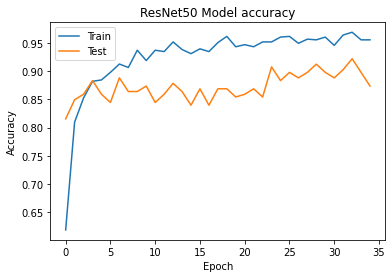

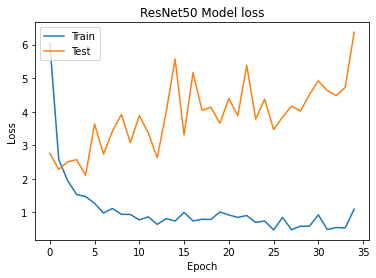

In [59]:
plt.plot(history_resnet50_model.history['accuracy'])
plt.plot(history_resnet50_model.history['val_accuracy'])
plt.title('ResNet50 Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_resnet50_model.history['loss'])
plt.plot(history_resnet50_model.history['val_loss'])
plt.title('ResNet50 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [60]:
x, y = zip(*(validation_generator[i] for i in range(len(validation_generator))))
x_test, y_test = np.vstack(x), np.vstack(y)
loss, acc = new_resnet50_model.evaluate(x_test, y_test, batch_size=32)

print("Accuracy: " ,acc)
print("Loss: ", loss)

7/7 [==============================] - 10s 1s/step - loss: 2.1063 - accuracy: 0.8592
Accuracy:  0.8592233061790466
Loss:  2.1063272953033447


### MobileNet

In [27]:
mobilenet_model = MobileNet(weights = 'imagenet', include_top=False, input_shape = (224, 224, 3))
mobilenet_model.summary()

17225924/17225924 [==============================] - 17s 1us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 3

 conv_dw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
          

In [28]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in mobilenet_model.layers:
    layer.trainable = False

#if fine_tune es decir cuantas capas quieres reentrenar
# for layer in base_model.layers[:-fine_tune]:
# layer.traineble = False

mobilenet_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [29]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# save the output of the last layer to be the input of the next layer
last_layer = mobilenet_model.output

# flatten the classifier input which is output of the last layer of ResNet152 model
x = Flatten(name="flatten")(last_layer)
#x = Dense(50, activation='relu')(x)
#x = Dense(30, activation='relu')(x)
x = Dense(num_classes, activation='softmax', name='softmax')(x)

# instantiate a new_model using keras’s Model class
new_mobilenet_model = Model(inputs=mobilenet_model.input, outputs=x)

# print the new_model summary
new_mobilenet_model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [30]:
new_mobilenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_mobilenet_model = new_mobilenet_model.fit(train_generator, batch_size=batch_size, validation_data=validation_generator, epochs=100, verbose=2, callbacks=[checkpoint, early_stop])

Epoch 1/100

Epoch 1: val_loss did not improve from 2.91193
26/26 - 29s - loss: 8.4033 - accuracy: 0.4613 - val_loss: 3.9200 - val_accuracy: 0.5825 - 29s/epoch - 1s/step
Epoch 2/100

Epoch 2: val_loss improved from 2.91193 to 2.16563, saving model to logs/ep002-val_loss2.166.h5
26/26 - 20s - loss: 2.6063 - accuracy: 0.6761 - val_loss: 2.1656 - val_accuracy: 0.7039 - 20s/epoch - 759ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 2.16563
26/26 - 19s - loss: 1.6054 - accuracy: 0.7485 - val_loss: 2.4924 - val_accuracy: 0.6990 - 19s/epoch - 746ms/step
Epoch 4/100

Epoch 4: val_loss improved from 2.16563 to 1.40615, saving model to logs/ep004-val_loss1.406.h5
26/26 - 20s - loss: 1.6979 - accuracy: 0.7399 - val_loss: 1.4061 - val_accuracy: 0.7864 - 20s/epoch - 759ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 1.40615
26/26 - 20s - loss: 1.6514 - accuracy: 0.7607 - val_loss: 2.5646 - val_accuracy: 0.6990 - 20s/epoch - 764ms/step
Epoch 6/100

Epoch 6: val_loss did not i

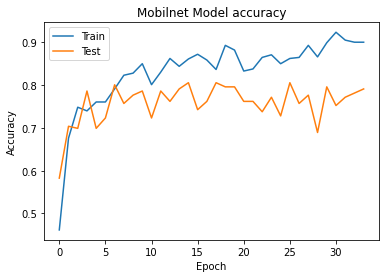

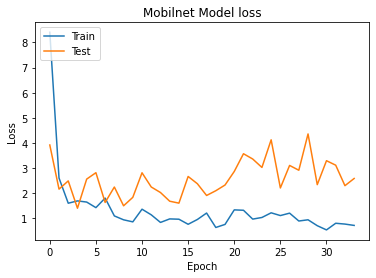

In [31]:
plt.plot(history_mobilenet_model.history['accuracy'])
plt.plot(history_mobilenet_model.history['val_accuracy'])
plt.title('Mobilnet Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_mobilenet_model.history['loss'])
plt.plot(history_mobilenet_model.history['val_loss'])
plt.title('Mobilnet Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [32]:
x, y = zip(*(validation_generator[i] for i in range(len(validation_generator))))
x_test, y_test = np.vstack(x), np.vstack(y)
loss, acc = new_mobilenet_model.evaluate(x_test, y_test, batch_size=32)

print("Accuracy: " ,acc)
print("Loss: ", loss)

7/7 [==============================] - 3s 399ms/step - loss: 1.4061 - accuracy: 0.7864
Accuracy:  0.7864077687263489
Loss:  1.4061450958251953


### InceptionV3

In [33]:
target_size = (299, 299) #inceptionv3

train_datagen_inception = ImageDataGenerator(horizontal_flip=True, 
                                   brightness_range=[0.5,1.5], 
                                   zoom_range=[0.3,1], 
                                   rotation_range=5)

train_generator_inception = train_datagen_inception.flow_from_directory(dataset_dir+'/train',
                                                 target_size=target_size,
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='training')

validation_datagen_inception = ImageDataGenerator()

validation_generator_inception = validation_datagen_inception.flow_from_directory(dataset_dir+'/val',
                                                            target_size=target_size,
                                                            batch_size=batch_size,
                                                            class_mode='categorical')


Found 815 images belonging to 6 classes.
Found 206 images belonging to 6 classes.


In [35]:
inception_v3_model = InceptionV3(weights = 'imagenet', include_top=False, input_shape = (299, 299, 3))
inception_v3_model.summary()

87910968/87910968 [==============================] - 72s 1us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)          

 conv2d_11 (Conv2D)             (None, 35, 35, 32)   6144        ['average_pooling2d[0][0]']      
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 35, 35, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 conv2d_22 (Conv2D)             (None, 35, 35, 64)   18432       ['mixed1[0][0]']                 
                                                                                                  
 batch_normalization_22 (BatchN  (None, 35, 35, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 35, 35, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23

                                                                                                  
 activation_29 (Activation)     (None, 17, 17, 96)   0           ['batch_normalization_29[0][0]'] 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 17, 17, 128)  98304       ['mixed3[0][0]']                 
          

                                                                  'activation_33[0][0]',          
                                                                  'activation_38[0][0]',          
                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 17, 17, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_44[0][0]'] 
          

                                                                                                  
 batch_normalization_54 (BatchN  (None, 17, 17, 160)  480        ['conv2d_54[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 17, 17, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 conv2d_65 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_64[0][0]']          
                                                                                                  
 batch_normalization_65 (BatchN  (None, 17, 17, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 17, 17, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66

                                                                                                  
 activation_73 (Activation)     (None, 17, 17, 192)  0           ['batch_normalization_73[0][0]'] 
                                                                                                  
 conv2d_70 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 17, 17, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_nor

 conv2d_84 (Conv2D)             (None, 8, 8, 192)    245760      ['average_pooling2d_7[0][0]']    
                                                                                                  
 batch_normalization_76 (BatchN  (None, 8, 8, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_82[0][0]'] 
          

                                                                                                  
 activation_88 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_88[0][0]'] 
                                                                                                  
 activation_91 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 8, 8, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

In [36]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in inception_v3_model.layers:
    layer.trainable = False

#if fine_tune es decir cuantas capas quieres reentrenar
# for layer in base_model.layers[:-fine_tune]:
# layer.traineble = False

inception_v3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

 batch_normalization_5 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 35, 35, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 35, 35, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 35, 35, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 35, 35, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 35, 35, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 17, 17, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 17, 17, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 17, 17, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 17, 17, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 17, 17, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 17, 17, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 17, 17, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 17, 17, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 8, 8, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 8, 8, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 8, 8, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

In [37]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# save the output of the last layer to be the input of the next layer
last_layer = inception_v3_model.output

# flatten the classifier input which is output of the last layer of inception model
x = Flatten(name="flatten")(last_layer)
#x = Dense(50, activation='relu')(x)
#x = Dense(30, activation='relu')(x)
x = Dense(num_classes, activation='softmax', name='softmax')(x)

# instantiate a new_model using keras’s Model class
new_inception_v3_model = Model(inputs=inception_v3_model.input, outputs=x)

# print the new_model summary
new_inception_v3_model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

 batch_normalization_5 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 35, 35, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 35, 35, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 35, 35, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 35, 35, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 35, 35, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 17, 17, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 17, 17, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 17, 17, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 17, 17, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 17, 17, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 17, 17, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 17, 17, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 17, 17, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 8, 8, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 8, 8, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 8, 8, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

In [38]:
new_inception_v3_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_inception_v3_model = new_inception_v3_model.fit(train_generator_inception, batch_size=batch_size, validation_data=validation_generator_inception, epochs=100, verbose=2, callbacks=[checkpoint, early_stop])

Epoch 1/100

Epoch 1: val_loss did not improve from 1.40615
26/26 - 77s - loss: 387.6045 - accuracy: 0.4098 - val_loss: 142.6267 - val_accuracy: 0.5097 - 77s/epoch - 3s/step
Epoch 2/100

Epoch 2: val_loss did not improve from 1.40615
26/26 - 74s - loss: 153.3712 - accuracy: 0.5178 - val_loss: 106.9717 - val_accuracy: 0.6214 - 74s/epoch - 3s/step
Epoch 3/100

Epoch 3: val_loss did not improve from 1.40615
26/26 - 74s - loss: 129.7802 - accuracy: 0.5325 - val_loss: 148.9859 - val_accuracy: 0.6019 - 74s/epoch - 3s/step
Epoch 4/100

Epoch 4: val_loss did not improve from 1.40615
26/26 - 73s - loss: 111.0818 - accuracy: 0.5890 - val_loss: 103.7273 - val_accuracy: 0.6117 - 73s/epoch - 3s/step
Epoch 5/100

Epoch 5: val_loss did not improve from 1.40615
26/26 - 71s - loss: 89.9576 - accuracy: 0.6319 - val_loss: 123.0881 - val_accuracy: 0.5631 - 71s/epoch - 3s/step
Epoch 6/100

Epoch 6: val_loss did not improve from 1.40615
26/26 - 73s - loss: 90.5085 - accuracy: 0.6380 - val_loss: 135.6033 - v

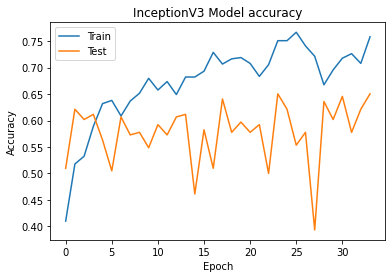

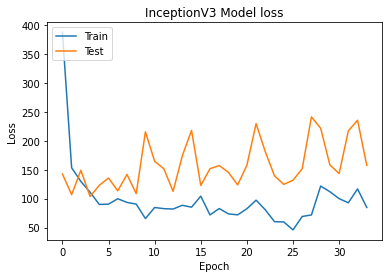

In [39]:
plt.plot(history_inception_v3_model.history['accuracy'])
plt.plot(history_inception_v3_model.history['val_accuracy'])
plt.title('InceptionV3 Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_inception_v3_model.history['loss'])
plt.plot(history_inception_v3_model.history['val_loss'])
plt.title('InceptionV3 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [40]:
x, y = zip(*(validation_generator_inception[i] for i in range(len(validation_generator_inception))))
x_test, y_test = np.vstack(x), np.vstack(y)
loss, acc = new_inception_v3_model.evaluate(x_test, y_test, batch_size=32)

print("Accuracy: " ,acc)
print("Loss: ", loss)

7/7 [==============================] - 13s 2s/step - loss: 103.7273 - accuracy: 0.6117
Accuracy:  0.6116504669189453
Loss:  103.7273178100586
